# Práctica 3: Clasificación con scikit-learn

## Importar módulos

In [73]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import sklearn
from sklearn import preprocessing, model_selection, neighbors, svm, tree, ensemble

## Seleccionar datasets

Los conjuntos de datos seleccionados se encuentran en el directorio `datasets`.

In [48]:
accent_df = pd.read_csv('datasets/accent.csv', header=0)
avila_df = pd.read_csv('datasets/avila.csv', header=0)
cancer_df = pd.read_csv('datasets/cancer.csv', header=0, na_values='?')
digits_df = pd.read_csv('datasets/digits.csv', header=None)
fertility_df = pd.read_csv('datasets/fertility.csv', header=0)
glass_df = pd.read_csv('datasets/glass.csv', header=0)
iris_df = pd.read_csv('datasets/iris.csv', header=None)
column_df = pd.read_csv('datasets/column.csv', header=0)
phishing_df = pd.read_csv('datasets/phishing.csv', header=None)
wine_df = pd.read_csv('datasets/wine.csv', header=0)

### Preprocesamiento
Aplicamos el mismo que en la práctica anterior, además de eliminar de Avila y Glass las clases con menos de 10 instancias para poder realizar 10-fold estratificado

In [49]:
accent_df = accent_df[accent_df.columns.to_list()[1:]+[accent_df.columns.to_list()[0]]]

In [50]:
cancer_df = cancer_df.drop('id', axis=1)

In [51]:
cancer_df.bare_nuclei = cancer_df.bare_nuclei.fillna(np.mean(cancer_df.bare_nuclei)).astype('int')

In [52]:
avila_df = avila_df[avila_df['class'] != 'B']
glass_df = glass_df[glass_df['class'] != 6]

In [53]:
dfs = [accent_df, avila_df, cancer_df, digits_df, fertility_df, glass_df, iris_df, column_df, phishing_df, wine_df]
df_names = ['Accents', 'Avila', 'Cancer', 'Digits', 'Fertility', 'Glass', 'Iris', 'Vertebral Column', 'Phishing', 'Wine'] 

In [54]:
for df in dfs:
    df.iloc[:,-1] = df.iloc[:,-1].astype('category')

In [55]:
X = [df.iloc[:, :-1].values for df in dfs]
y = [df.iloc[:, -1].values for df in dfs]

## 1. Seleccionar clasificadores

Usaremos los clasificadores siguientes:
- `sklearn.neighbors.KNeighborsClassifier`
- `sklearn.tree.DecisionTreeClassifier`
- `sklearn.svm.SVC`

## 2. Comparar método base con _ensemble_

### 2.1 Entrenar y aplicar el método base

Usaremos el método _hold out_ con porcentajes 70% entrenamiento y 30% test. Realizaremos 5 entrenamientos distintos con cada dataset. 

In [70]:
knn_scores = np.empty((len(dfs), 10))
svc_scores = np.empty((len(dfs), 10))
dtree_scores = np.empty((len(dfs), 10))


for i in range(len(dfs)):
    knn_scores[i] = model_selection.cross_val_score(neighbors.KNeighborsClassifier(), X[i], y[i], cv=10)
    svc_scores[i] = model_selection.cross_val_score(svm.SVC(), X[i], y[i], cv=10)
    dtree_scores[i] = model_selection.cross_val_score(tree.DecisionTreeClassifier() ,X[i], y[i], cv=10)

In [71]:
average_knn_scores = [np.mean(x) for x in knn_scores]
knn_score_std = [np.std(x) for x in knn_scores]

average_dtree_scores = [np.mean(x) for x in dtree_scores]
dtree_score_std = [np.std(x) for x in dtree_scores]

average_svc_scores = [np.mean(x) for x in svc_scores]
svc_score_std = [np.std(x) for x in svc_scores]

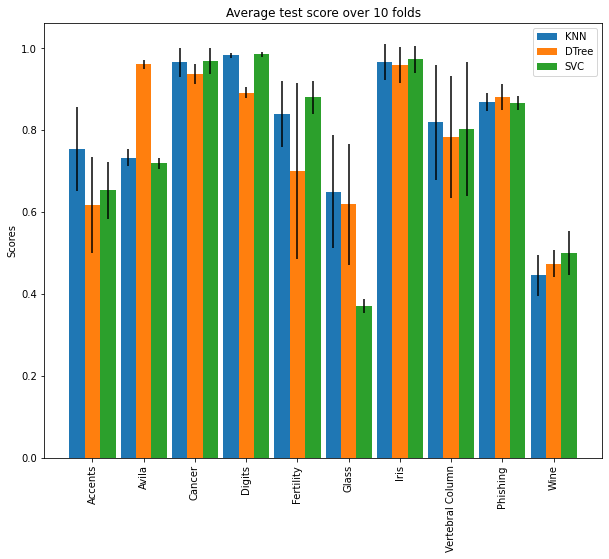

In [72]:
x = np.arange(len(dfs)*2, step=2)  # the label locations
width = 0.6  # the width of the bars

fig, ax = plt.subplots(figsize=(10,8))

ax.bar(x - width, average_knn_scores, width, label='KNN', yerr=knn_score_std)
ax.bar(x, average_dtree_scores, width, label='DTree', yerr=dtree_score_std)
ax.bar(x + width, average_svc_scores, width, label='SVC', yerr=svc_score_std)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Average test score over 10 folds')
ax.set_xticks(x)
ax.set_xticklabels(df_names, rotation='vertical')
ax.legend()

plt.show()

### 2.2 Aplicar Bagging a los clasificadores

In [77]:
knn_bagging = ensemble.BaggingClassifier(neighbors.KNeighborsClassifier(), max_samples=.7)
dtree_bagging = ensemble.BaggingClassifier(tree.DecisionTreeClassifier(), max_samples=.7)
svc_bagging = ensemble.BaggingClassifier(svm.SVC(), max_samples=.7)

In [78]:
knn_bagging_scores = np.empty((len(dfs), 10))
svc_bagging_scores = np.empty((len(dfs), 10))
dtree_bagging_scores = np.empty((len(dfs), 10))


for i in range(len(dfs)):
    knn_bagging_scores[i] = model_selection.cross_val_score(knn_bagging, X[i], y[i], cv=10)
    svc_bagging_scores[i] = model_selection.cross_val_score(svc_bagging, X[i], y[i], cv=10)
    dtree_bagging_scores[i] = model_selection.cross_val_score(dtree_bagging ,X[i], y[i], cv=10)

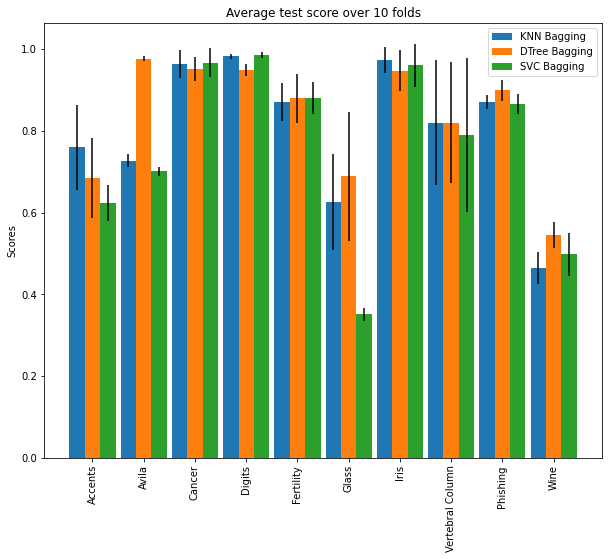

In [79]:
average_knn_b_scores = [np.mean(x) for x in knn_bagging_scores]
knn_b_score_std = [np.std(x) for x in knn_bagging_scores]

average_dtree_b_scores = [np.mean(x) for x in dtree_bagging_scores]
dtree_b_score_std = [np.std(x) for x in dtree_bagging_scores]

average_svc_b_scores = [np.mean(x) for x in svc_bagging_scores]
svc_b_score_std = [np.std(x) for x in svc_bagging_scores]

x = np.arange(len(dfs)*2, step=2)  # the label locations
width = 0.6  # the width of the bars

fig, ax = plt.subplots(figsize=(10,8))

ax.bar(x - width, average_knn_b_scores, width, label='KNN Bagging', yerr=knn_b_score_std)
ax.bar(x, average_dtree_b_scores, width, label='DTree Bagging', yerr=dtree_b_score_std)
ax.bar(x + width, average_svc_b_scores, width, label='SVC Bagging', yerr=svc_b_score_std)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Average test score over 10 folds')
ax.set_xticks(x)
ax.set_xticklabels(df_names, rotation='vertical')
ax.legend()

plt.show()

## 4. Métodos de comparación y evaluación de algoritmos

Aplicaremos el test de Wilcoxon a los algoritmos KNN y SVM.

In [315]:
winner = []
difference = []

for i in range(len(dfs)):
    diff = average_knn_scores[i]-average_dtree_scores[i]
    difference.append(
        (abs(diff), i)
    )
    w = 1 if diff > 0 else -1
    winner.append(w)
    
difference.sort(key=lambda x: x[0])

r_plus = 0
r_minus = 0
for i, d in enumerate(difference):
    if winner[d[1]] == 1:
        r_plus += i+1
    else:
        r_minus += i+1


Mirando en la  tabla del test de Wilcoxon, para $N=10$ datasets y $\alpha=0.05$, el menor de $R^+$ y $R^-$ debe ser menor o igual que 8 para que la diferencia entre los clasificadores sea significativa.

In [316]:
print(min(r_plus, r_minus))

21


Viendo que no lo es, podemos afirmar que no hay una diferencia de rendimiento entre ellos.

## 6. Aplicar GridSearch a un clasificador

Lo haremos con KNN, variando el número de vecinos $K$, el peso de los votos entre uniforme y basado en distancia, y la métrica de distancia (euclídea o manhattan)

In [330]:
knn_gc_scores_train = np.zeros(len(dfs))
knn_gc_scores_test = np.zeros(len(dfs))

for i in range(len(dfs)):
        X_train, X_test, y_train, y_test = model_selection.train_test_split(X[i], y[i], test_size=.3)
        sc = preprocessing.MinMaxScaler()
        sc.fit_transform(X_train)
        sc.transform(X_test)
        
        Ks = np.arange(start=3, stop=12, step=2)
        weigths = ['uniform', 'distance']
        ps = [1, 2]
        
        optimal = model_selection.GridSearchCV(
            estimator=neighbors.KNeighborsClassifier(),
            param_grid=dict(n_neighbors=Ks, weights=weigths, p=ps),
            cv=3)
        
        optimal.fit(X_train, y_train)
        
 
        knn_gc_scores_train[i] = optimal.score(X_train, y_train)*100
        knn_gc_scores_test[i] = optimal.score(X_test, y_test)*100



In [346]:
print('KNN with GridSearch Scores')
print('==========================')
for i in range(len(dfs)):
    print(f'{df_names[i]}:')
    print(f'\tTrain -> {knn_gc_scores_train[i]:.2f}')
    print(f'\tTest -> {knn_gc_scores_test[i]:.2f}')
    print(f'\t{knn_gc_scores_test[i] - average_knn_scores[i]:.2f} variation wrt to default parameters')
print(f'\nAverage variation = {np.mean(knn_gc_scores_test - average_knn_scores):.2f}')

KNN with GridSearch Scores
Accents:
	Train -> 100.00
	Test -> 83.84
	6.26 variation wrt to default parameters
Avila:
	Train -> 100.00
	Test -> 82.18
	11.36 variation wrt to default parameters
Cancer:
	Train -> 100.00
	Test -> 97.62
	1.14 variation wrt to default parameters
Digits:
	Train -> 100.00
	Test -> 99.05
	0.60 variation wrt to default parameters
Fertility:
	Train -> 88.57
	Test -> 83.33
	-2.00 variation wrt to default parameters
Glass:
	Train -> 100.00
	Test -> 64.62
	-2.15 variation wrt to default parameters
Iris:
	Train -> 100.00
	Test -> 93.33
	-2.67 variation wrt to default parameters
Vertebral Column:
	Train -> 100.00
	Test -> 89.25
	3.87 variation wrt to default parameters
Phishing:
	Train -> 97.36
	Test -> 87.93
	2.22 variation wrt to default parameters
Wine:
	Train -> 100.00
	Test -> 62.29
	12.96 variation wrt to default parameters

Average variation = 3.16


Vemos que en general, los resultados son mucho mejores, con un incremento medio del CCR de un 3% frente a los parámetros por defecto, que llega hasta el 13% en algunos casos.